# SDWFS AGN Color--Color Plane Plot
## Author: Benjamin Floyd

Generates a publication plot of the SDWFS AGN color--color plane showing both Stern+05 and Donley+12 selections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

In [2]:
# Read in the SDWFS photometric catalog
sdwfs_main = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat.gz',
                        names=['ID', 'IRAC_RA', 'IRAC_DEC', 'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4', 'B_APFLUXERR4',
                               'R_APFLUXERR4', 'I_APFLUXERR4', 'B_APMAG4', 'R_APMAG4', 'I_APMAG4', 'B_APMAGERR4',
                               'R_APMAGERR4', 'I_APMAGERR4', 'CH1_APFLUX4', 'CH2_APFLUX4', 'CH3_APFLUX4', 'CH4_APFLUX4',
                               'CH1_APFLUXERR4', 'CH2_APFLUXERR4', 'CH3_APFLUXERR4', 'CH4_APFLUXERR4',
                               'CH1_APFLUXERR4_BROWN', 'CH2_APFLUXERR4_BROWN', 'CH3_APFLUXERR4_BROWN',
                               'CH4_APFLUXERR4_BROWN', 'CH1_APMAG4', 'CH2_APMAG4', 'CH3_APMAG4', 'CH4_APMAG4',
                               'CH1_APMAGERR4', 'CH2_APMAGERR4', 'CH3_APMAGERR4', 'CH4_APMAGERR4',
                               'CH1_APMAGERR4_BROWN', 'CH2_APMAGERR4_BROWN', 'CH3_APMAGERR4_BROWN',
                               'CH4_APMAGERR4_BROWN', 'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'],
                        format='ascii')

# Read in the photometric redshift catalog
sdwfs_photz = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/mbz_v0.06_prior_bri12_18p8.cat.gz',
                         names=['ID', 'PHOT_Z', 'col3', 'col4', 'col5', 'col6', 'col7'],
                         format='ascii',
                         include_names=['ID', 'PHOT_Z'])

# Join the two catalogs together
sdwfs_cat = join(sdwfs_main, sdwfs_photz, keys='ID')

In [3]:
# Impose our magnitude cuts used in AGN selection for 3.6 um and 4.5 um and require SNR > 5 for 5.8 um and 8.0 um.
sdwfs_cat = sdwfs_cat[(sdwfs_cat['CH1_APMAG4'] > 10.00) & (sdwfs_cat['CH1_APMAG4'] <= 18.30) &  # 10. < [3.6] <= 18.3
                      (sdwfs_cat['CH2_APMAG4'] > 10.45) & (sdwfs_cat['CH2_APMAG4'] <= 17.46) &  # 10.45 < [4.5] <= 17.46
                      (sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH3_APFLUXERR4'] >= 5) &           # SNR_5.8 >= 5
                      (sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH4_APFLUXERR4'] >= 5)]            # SNR_8.0 >= 5

In [4]:
# For convenience, add columns for the two colors
sdwfs_cat['CH1_CH2_COLOR'] = sdwfs_cat['CH1_APMAG4'] - sdwfs_cat['CH2_APMAG4']
sdwfs_cat['CH3_CH4_COLOR'] = sdwfs_cat['CH3_APMAG4'] - sdwfs_cat['CH4_APMAG4']

# And add columns for the log flux ratios
sdwfs_cat['CH3_CH1_LOG_FLUX'] = np.log10(sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH1_APFLUX4'])
sdwfs_cat['CH4_CH2_LOG_FLUX'] = np.log10(sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH2_APFLUX4'])

In [5]:
# Make AGN selections using the Stern+05 wedge selection
stern_agn = sdwfs_cat[(sdwfs_cat['CH3_CH4_COLOR'] > 0.6) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 0.2 * sdwfs_cat['CH3_CH4_COLOR'] + 0.18) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 2.5 * sdwfs_cat['CH3_CH4_COLOR'] - 3.5)]

donley_agn = sdwfs_cat[(sdwfs_cat['CH3_CH1_LOG_FLUX'] >= 0.08) & (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 0.15) &
                       (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] - 0.27) &
                       (sdwfs_cat['CH4_CH2_LOG_FLUX'] <= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] + 0.27) &
                       (sdwfs_cat['CH2_APFLUX4'] > sdwfs_cat['CH1_APFLUX4']) &
                       (sdwfs_cat['CH3_APFLUX4'] > sdwfs_cat['CH2_APFLUX4']) &
                       (sdwfs_cat['CH4_APFLUX4'] > sdwfs_cat['CH3_APFLUX4'])]

In [6]:
# Identify the IDs of the objects outside the Stern-wedge selection to create a sample of non-AGN.
stern_complement_ids = list(set(sdwfs_cat['ID']) - set(stern_agn['ID']))
non_agn = sdwfs_cat[np.in1d(sdwfs_cat['ID'], stern_complement_ids)]

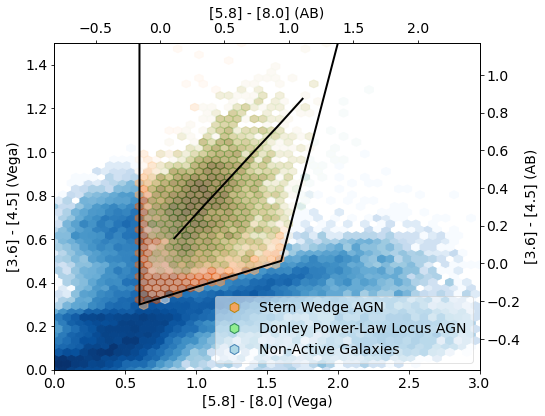

In [7]:
# Make plot
fig, ax = plt.subplots(figsize=(7.8, 6))
# Sample hexbins
ax.hexbin(non_agn['CH3_CH4_COLOR'], non_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 3., 0., 1.5), cmap='Blues', bins='log', mincnt=1)
ax.hexbin(stern_agn['CH3_CH4_COLOR'], stern_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 3., 0., 1.5), cmap='Oranges', bins='log', mincnt=1, alpha=0.5)
ax.hexbin(donley_agn['CH3_CH4_COLOR'], donley_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 3., 0., 1.5), cmap='Greens', bins='log', mincnt=1, alpha=0.3)

# Stern wedge bounds
ymin, ymax = ax.get_ylim()
ax.add_patch(Polygon([(0.6, ymax), (0.6, 0.3), (1.6, 0.5), ((ymax + 3.5) / 2.5, ymax)], closed=False, fill=False, color='k', lw=2))

# Donley Power-law Locus line
donley_power_law = np.array([
    (0.845548715203426, 0.603526498929336),
    (1.0233444860813707, 0.7314079229122057),
    (1.2077368843683087, 0.8605112419700212),
    (1.3888329764453962, 0.9883953426124196),
    (1.5732293897216276, 1.1162821199143467),
    (1.7510251605995724, 1.244163543897216)]).T
ax.plot(donley_power_law[0], donley_power_law[1], lw=2, c='k')

# Add AB colors on right axis
min_color_y, max_color_y = ax.get_ylim()
ax2 = ax.twinx()
ax2.set(ylabel='[3.6] - [4.5] (AB)', ylim=[min_color_y+2.779-3.264, max_color_y+2.779-3.264])

# Add AB colors on top axis
min_color_x, max_color_x = ax.get_xlim()
ax3 = ax.twiny()
ax3.set(xlabel='[5.8] - [8.0] (AB)', xlim=[min_color_x+3.73-4.40, max_color_x+3.73-4.40])

# Make legend
handles, labels = ax.get_legend_handles_labels()
handles.extend([Line2D([0], [0], marker='h', color='none', markerfacecolor='sandybrown', markeredgecolor='darkgoldenrod', markersize=10),
                Line2D([0], [0], marker='h', color='none', markerfacecolor='lightgreen', markeredgecolor='seagreen', markersize=10),
                Line2D([0], [0], marker='h', color='none', markerfacecolor='lightblue', markeredgecolor='steelblue', markersize=10)])
labels.extend(['Stern Wedge AGN', 'Donley Power-Law Locus AGN', 'Non-Active Galaxies'])
ax.legend(handles, labels, frameon=True, loc='lower right', framealpha=0.55)

ax.set(xlabel='[5.8] - [8.0] (Vega)', ylabel='[3.6] - [4.5] (Vega)', xlim=[0, 3], ylim=[0, 1.5])
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color-color_publication.pdf')

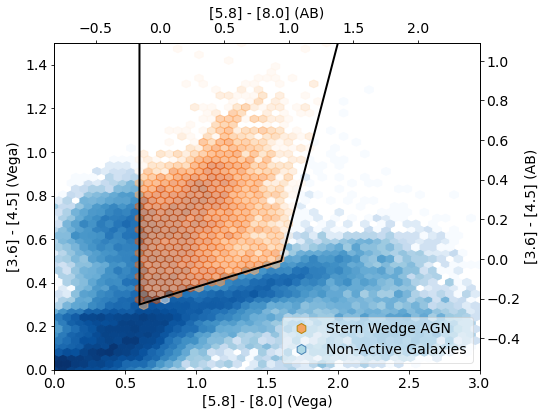

In [8]:
# Make plot
fig, ax = plt.subplots(figsize=(7.8, 6))
# Sample hexbins
ax.hexbin(non_agn['CH3_CH4_COLOR'], non_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 3., 0., 1.5), cmap='Blues',
          bins='log', mincnt=1)
ax.hexbin(stern_agn['CH3_CH4_COLOR'], stern_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 3., 0., 1.5), cmap='Oranges',
          bins='log', mincnt=1, alpha=0.5)

# Stern wedge bounds
ymin, ymax = ax.get_ylim()
ax.add_patch(
    Polygon([(0.6, ymax), (0.6, 0.3), (1.6, 0.5), ((ymax + 3.5) / 2.5, ymax)], closed=False, fill=False, color='k',
            lw=2))

# Add AB colors on right axis
min_color_y, max_color_y = ax.get_ylim()
ax2 = ax.twinx()
ax2.set(ylabel='[3.6] - [4.5] (AB)', ylim=[min_color_y + 2.779 - 3.264, max_color_y + 2.779 - 3.264])

# Add AB colors on top axis
min_color_x, max_color_x = ax.get_xlim()
ax3 = ax.twiny()
ax3.set(xlabel='[5.8] - [8.0] (AB)', xlim=[min_color_x + 3.73 - 4.40, max_color_x + 3.73 - 4.40])

# Make legend
handles, labels = ax.get_legend_handles_labels()
handles.extend([Line2D([0], [0], marker='h', color='none', markerfacecolor='sandybrown', markeredgecolor='darkgoldenrod', markersize=10),
                Line2D([0], [0], marker='h', color='none', markerfacecolor='lightblue', markeredgecolor='steelblue', markersize=10)])
labels.extend(['Stern Wedge AGN', 'Non-Active Galaxies'])
ax.legend(handles, labels, frameon=True, loc='lower right', framealpha=0.55)

ax.set(xlabel='[5.8] - [8.0] (Vega)', ylabel='[3.6] - [4.5] (Vega)', xlim=[0, 3], ylim=[0, 1.5])
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color-color_publication_stern_only.pdf')